In [ ]:
!pip install --upgrade gensim
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
import nltk.corpus
import nltk.tokenize
import string
from string import punctuation
import torch
import gensim
from gensim.models.word2vec import Word2Vec
import torch.nn as nn
import torch.nn.functional as F
import scipy
import pickle
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/ER/KP/train_sent_emo.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ER/KP/test_sent_emo.csv')
df_dev = pd.read_csv('/content/drive/MyDrive/ER/KP/dev_sent_emo.csv')

In [ ]:
data_train = df_train.loc[:,['Utterance','Emotion','Sentiment']]
data_test = df_test.loc[:,['Utterance','Emotion','Sentiment']]
data_dev = df_dev.loc[:,['Utterance','Emotion','Sentiment']]

In [ ]:
data_train.loc[(data_train.Emotion == 'neutral'),'Emotion'] = 0
data_train.loc[(data_train.Emotion == 'anger'),'Emotion'] = 1
data_train.loc[(data_train.Emotion == 'disgust'),'Emotion'] = 2
data_train.loc[(data_train.Emotion == 'fear'),'Emotion'] = 3
data_train.loc[(data_train.Emotion == 'joy'),'Emotion'] = 4
data_train.loc[(data_train.Emotion == 'sadness'),'Emotion'] = 5
data_train.loc[(data_train.Emotion == 'surprise'),'Emotion'] = 6
data_train.loc[(data_train.Sentiment == 'neutral'),'Sentiment'] = 0
data_train.loc[(data_train.Sentiment == 'positive'),'Sentiment'] = 1
data_train.loc[(data_train.Sentiment == 'negative'),'Sentiment'] = 2
data_train

,Utterance,Emotion,Sentiment
0,also I was the point person on my companys tr...,0,0
1,You mustve had your hands full.,0,0
2,That I did. That I did.,0,0
3,So lets talk a little bit about your duties.,0,0
4,My duties? All right.,6,1
...,...,...,...
9984,You or me?,0,0
9985,"I got it. Uh, Joey, women don't have Adam's ap...",0,0
9986,"You guys are messing with me, right?",6,1
9987,Yeah.,0,0


In [ ]:
data_test.loc[(data_test.Emotion == 'neutral'),'Emotion'] = 0
data_test.loc[(data_test.Emotion == 'anger'),'Emotion'] = 1
data_test.loc[(data_test.Emotion == 'disgust'),'Emotion'] = 2
data_test.loc[(data_test.Emotion == 'fear'),'Emotion'] = 3
data_test.loc[(data_test.Emotion == 'joy'),'Emotion'] = 4
data_test.loc[(data_test.Emotion == 'sadness'),'Emotion'] = 5
data_test.loc[(data_test.Emotion == 'surprise'),'Emotion'] = 6
data_test.loc[(data_test.Sentiment == 'neutral'),'Sentiment'] = 0
data_test.loc[(data_test.Sentiment == 'positive'),'Sentiment'] = 1
data_test.loc[(data_test.Sentiment == 'negative'),'Sentiment'] = 2

data_dev.loc[(data_dev.Emotion == 'neutral'),'Emotion'] = 0
data_dev.loc[(data_dev.Emotion == 'anger'),'Emotion'] = 1
data_dev.loc[(data_dev.Emotion == 'disgust'),'Emotion'] = 2
data_dev.loc[(data_dev.Emotion == 'fear'),'Emotion'] = 3
data_dev.loc[(data_dev.Emotion == 'joy'),'Emotion'] = 4
data_dev.loc[(data_dev.Emotion == 'sadness'),'Emotion'] = 5
data_dev.loc[(data_dev.Emotion == 'surprise'),'Emotion'] = 6
data_dev.loc[(data_dev.Sentiment == 'neutral'),'Sentiment'] = 0
data_dev.loc[(data_dev.Sentiment == 'positive'),'Sentiment'] = 1
data_dev.loc[(data_dev.Sentiment == 'negative'),'Sentiment'] = 2

In [ ]:
data = pd.concat([data_train, data_test, data_dev]).reset_index().drop(['index'],axis=1)

In [ ]:
data_pos_train = data_train[data_train['Sentiment']==1]
data_neg_train = data_train[data_train['Sentiment']==2]
data_pos_test = data_test[data_test['Sentiment']==1]
data_neg_test = data_test[data_test['Sentiment']==2]
data_pos_dev = data_dev[data_dev['Sentiment']==1]
data_neg_dev = data_dev[data_dev['Sentiment']==2]

In [ ]:
utterances_train = data_train['Utterance'].values.tolist()
utterances_test = data_test['Utterance'].values.tolist()
utterances_dev = data_dev['Utterance'].values.tolist()

utterances = data['Utterance'].values.tolist()

utterances_pos_train = data_pos_train['Utterance'].values.tolist()
utterances_pos_test = data_pos_test['Utterance'].values.tolist()
utterances_pos_dev = data_pos_dev['Utterance'].values.tolist()
utterances_neg_train = data_neg_train['Utterance'].values.tolist()
utterances_neg_test = data_neg_test['Utterance'].values.tolist()
utterances_neg_dev = data_neg_dev['Utterance'].values.tolist()

In [ ]:
import re

In [ ]:
#чистим текст
words_train = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_train]
with open('words_message_train','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_train))

words_test = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_test]
with open('words_message_test','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_test))

words_dev = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_dev]
with open('words_message_dev','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_dev))

words = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances]
with open('words_message','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words))

words_pos_train = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_pos_train]
with open('words_message_pos_train','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_pos_train))

words_pos_test = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_pos_test]
with open('words_message_pos_test','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_pos_test))

words_pos_dev = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_pos_dev]
with open('words_message_pos_dev','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_pos_dev))

words_neg_train = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_neg_train]
with open('words_message_neg_train','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_neg_train))

words_neg_test = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_neg_test]
with open('words_message_neg_test','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_neg_test))

words_neg_dev = [re.sub(r'[^\w\s]|\n','',message.lower()) for message in utterances_neg_dev]
with open('words_message_neg_dev','w',encoding = 'utf-8') as f:
    f.write('\n'.join(words_neg_dev))

In [ ]:
df_utterances_train=pd.read_csv('words_message_train',delimiter=';', header=None)
df_utterances_test=pd.read_csv('words_message_test',delimiter=';', header=None)
df_utterances_dev=pd.read_csv('words_message_dev',delimiter=';', header=None)

df_utterances=pd.read_csv('words_message',delimiter=';', header=None)

df_utterances_pos_train=pd.read_csv('words_message_pos_train',delimiter=';', header=None)
df_utterances_pos_test=pd.read_csv('words_message_pos_test',delimiter=';', header=None)
df_utterances_pos_dev=pd.read_csv('words_message_pos_dev',delimiter=';', header=None)
df_utterances_neg_train=pd.read_csv('words_message_neg_train',delimiter=';', header=None)
df_utterances_neg_test=pd.read_csv('words_message_neg_test',delimiter=';', header=None)
df_utterances_neg_dev=pd.read_csv('words_message_neg_dev',delimiter=';', header=None)

df_utterances_train

,0
0,also i was the point person on my companys tra...
1,you mustve had your hands full
2,that i did that i did
3,so lets talk a little bit about your duties
4,my duties all right
...,...
9983,you or me
9984,i got it uh joey women dont have adams apples
9985,you guys are messing with me right
9986,yeah


In [ ]:
from gensim.test.utils import datapath
from nltk.tokenize import word_tokenize
from gensim import utils
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Разбиваем на токены
class Corpus:
    def __init__(self,data_path):
        self.dpath = data_path
    def __iter__(self):
        path = datapath(self.dpath)
        for line in open(path):
            yield word_tokenize(line)

tokens_train = Corpus('/content/words_message_train')
tokens_test = Corpus('/content/words_message_test')
tokens_dev = Corpus('/content/words_message_dev')

tokens_pos_train = Corpus('/content/words_message_pos_train')
tokens_pos_test = Corpus('/content/words_message_pos_test')
tokens_pos_dev = Corpus('/content/words_message_pos_dev')

tokens_neg_train = Corpus('/content/words_message_neg_train')
tokens_neg_test = Corpus('/content/words_message_neg_test')
tokens_neg_dev = Corpus('/content/words_message_neg_dev')

In [ ]:
i=1
for token in tokens_train:
    if i==10:
        break
    i+=1
    print(token)

['also', 'i', 'was', 'the', 'point', 'person', 'on', 'my', 'companys', 'transition', 'from', 'the', 'kl5', 'to', 'gr6', 'system']
['you', 'mustve', 'had', 'your', 'hands', 'full']
['that', 'i', 'did', 'that', 'i', 'did']
['so', 'lets', 'talk', 'a', 'little', 'bit', 'about', 'your', 'duties']
['my', 'duties', 'all', 'right']
['now', 'youll', 'be', 'heading', 'a', 'whole', 'division', 'so', 'youll', 'have', 'a', 'lot', 'of', 'duties']
['i', 'see']
['but', 'therell', 'be', 'perhaps', '30', 'people', 'under', 'you', 'so', 'you', 'can', 'dump', 'a', 'certain', 'amount', 'on', 'them']
['good', 'to', 'know']


In [ ]:
import gensim

In [ ]:
!gzip -d /content/drive/MyDrive/ER/KP/GoogleNews-vectors-negative300.bin.gz

gzip: /content/drive/MyDrive/ER/KP/GoogleNews-vectors-negative300.bin.gz: No such file or directory


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/ER/KP/GoogleNews-vectors-negative300.bin', binary=True)
model.init_sims(replace=True)

<ipython-input-19-ba65c425f37b>:2: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [ ]:
def word_averaging(inner_model, words):
    all_words, mean = set(), []

    for word in words:
        if word in inner_model.key_to_index.keys():
            mean.append(inner_model[inner_model.key_to_index[word]])
            all_words.add(inner_model.key_to_index[word])

    if not mean:
        #logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(inner_model.vector_size)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(inner_model, text_list):
    return np.vstack([word_averaging(inner_model, comment_text) for comment_text in text_list ])

In [ ]:
X_train_w2v_pred = word_averaging_list(model, tokens_train)
X_train_w2v_pred.shape

(9989, 300)

In [ ]:
df_X_train_w2v_pred = pd.DataFrame(X_train_w2v_pred)
df_X_train_w2v_pred.to_csv('X_train_w2v_pred.csv')
df_X_train_w2v_pred

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.044454,-0.008293,0.038648,0.116581,-0.062159,-0.025245,0.036712,-0.122128,0.044095,0.028428,...,-0.115392,0.023060,-0.072356,-0.015792,-0.059786,0.038342,-0.024820,-0.031909,0.016810,-0.069064
1,0.063908,-0.000217,-0.009744,0.117103,-0.101888,-0.007697,0.030968,-0.069691,-0.011938,0.057265,...,-0.082997,0.079974,-0.125555,-0.022160,-0.004310,-0.035105,0.035084,-0.093017,-0.081750,0.035776
2,-0.004913,0.018451,0.070322,0.064591,-0.047054,-0.005253,-0.011241,-0.068140,0.061575,0.018257,...,0.004181,0.024396,-0.085703,0.014784,-0.013051,0.039793,0.009396,-0.043898,-0.007843,-0.088221
3,0.107726,0.037694,0.006864,0.085481,-0.056941,0.050526,0.102420,-0.075604,0.017041,0.081022,...,-0.052544,0.068241,-0.055677,-0.013109,-0.082435,-0.028898,0.063247,-0.014505,0.002343,-0.011908
4,0.085770,0.001393,0.040668,0.086524,-0.039206,-0.080308,0.077379,-0.056953,-0.007602,0.031195,...,-0.034865,0.029414,-0.055245,-0.075193,-0.066838,0.022768,0.063330,-0.011813,-0.023401,-0.020344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,0.067610,-0.049552,0.061157,0.134191,-0.046123,0.053986,0.016920,0.001972,-0.027963,0.037841,...,-0.036583,0.145387,-0.094983,-0.050715,-0.004691,-0.021009,0.014172,-0.086076,-0.035492,0.023173
9985,-0.042592,0.020186,-0.024564,0.109545,-0.042984,-0.050117,-0.015690,-0.055362,-0.014233,0.067626,...,0.016088,0.096561,-0.049467,0.027876,-0.053101,-0.039384,-0.004328,-0.054621,-0.020911,0.015385
9986,0.065651,0.017429,0.043154,0.132808,-0.045505,0.004368,-0.014890,-0.053602,-0.010486,0.055118,...,0.003727,0.116565,-0.131398,-0.052067,-0.032718,-0.002205,0.021927,-0.083335,0.000711,-0.003239
9987,0.091104,-0.016834,-0.028268,0.121712,0.052214,-0.034209,-0.054014,-0.025927,0.025747,0.031508,...,0.026647,0.102267,-0.073099,0.013053,-0.069499,-0.050413,0.031508,-0.083902,0.005694,-0.024126


In [ ]:
X_test_w2v_pred = word_averaging_list(model, tokens_test)
df_X_test_w2v_pred = pd.DataFrame(X_test_w2v_pred)
df_X_test_w2v_pred.to_csv('X_test_w2v_pred.csv')

X_dev_w2v_pred = word_averaging_list(model, tokens_dev)
df_X_dev_w2v_pred = pd.DataFrame(X_dev_w2v_pred)
df_X_dev_w2v_pred.to_csv('X_dev_w2v_pred.csv')

X_pos_train_w2v_pred = word_averaging_list(model, tokens_pos_train)
df_X_pos_train_w2v_pred = pd.DataFrame(X_pos_train_w2v_pred)
df_X_pos_train_w2v_pred.to_csv('X_pos_train_w2v_pred.csv')

X_pos_test_w2v_pred = word_averaging_list(model, tokens_pos_test)
df_X_pos_test_w2v_pred = pd.DataFrame(X_pos_test_w2v_pred)
df_X_pos_test_w2v_pred.to_csv('X_pos_test_w2v_pred.csv')

X_pos_dev_w2v_pred = word_averaging_list(model, tokens_pos_dev)
df_X_pos_dev_w2v_pred = pd.DataFrame(X_pos_dev_w2v_pred)
df_X_pos_dev_w2v_pred.to_csv('X_pos_dev_w2v_pred.csv')

X_neg_train_w2v_pred = word_averaging_list(model, tokens_neg_train)
df_X_neg_train_w2v_pred = pd.DataFrame(X_neg_train_w2v_pred)
df_X_neg_train_w2v_pred.to_csv('X_neg_train_w2v_pred.csv')

X_neg_test_w2v_pred = word_averaging_list(model, tokens_neg_test)
df_X_neg_test_w2v_pred = pd.DataFrame(X_neg_test_w2v_pred)
df_X_neg_test_w2v_pred.to_csv('X_neg_test_w2v_pred.csv')

X_neg_dev_w2v_pred = word_averaging_list(model, tokens_neg_dev)
df_X_neg_dev_w2v_pred = pd.DataFrame(X_neg_dev_w2v_pred)
df_X_neg_dev_w2v_pred.to_csv('X_neg_dev_w2v_pred.csv')

In [ ]:
y_e_train = data_train.loc[:,'Emotion'].to_list()
y_s_train = data_train.loc[:,'Sentiment'].to_list()

y_e_test = data_test.loc[:,'Emotion'].to_list()
y_s_test = data_test.loc[:,'Sentiment'].to_list()

y_e_dev = data_dev.loc[:,'Emotion'].to_list()
y_s_dev = data_dev.loc[:,'Sentiment'].to_list()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing

In [ ]:
X_train = df_X_train_w2v_pred
X_test = df_X_test_w2v_pred
X_dev = df_X_dev_w2v_pred

In [ ]:
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_dev = preprocessing.StandardScaler().fit(X_dev).transform(X_dev)

# **Baseline**

## **Метод опорных векторов (Sentiment)**

In [ ]:
svm = LinearSVC(C=5, max_iter=10000000)
svm.fit(X_train, y_s_train)
predicted = svm.predict(X_test)
print(metrics.classification_report(y_s_test, predicted))
print(metrics.confusion_matrix(y_s_test, predicted))

              precision    recall  f1-score   support

           0       0.57      0.77      0.65      1256
           1       0.55      0.31      0.40       521
           2       0.55      0.40      0.47       833

    accuracy                           0.56      2610
   macro avg       0.55      0.49      0.51      2610
weighted avg       0.56      0.56      0.54      2610

[[962  86 208]
 [293 163  65]
 [446  50 337]]


## **Метод опорных векторов (Emotion)**

In [ ]:
svm = LinearSVC(C=5,max_iter=10000000)
svm.fit(X_train, y_e_train)
predicted = svm.predict(X_test)
print(metrics.classification_report(y_e_test, predicted, zero_division=0))
print(metrics.confusion_matrix(y_e_test, predicted))

              precision    recall  f1-score   support

           0       0.54      0.89      0.67      1256
           1       0.40      0.08      0.14       345
           2       0.44      0.06      0.10        68
           3       0.00      0.00      0.00        50
           4       0.47      0.25      0.33       402
           5       0.43      0.10      0.16       208
           6       0.50      0.36      0.42       281

    accuracy                           0.52      2610
   macro avg       0.40      0.25      0.26      2610
weighted avg       0.49      0.52      0.45      2610

[[1112   17    3    4   58   13   49]
 [ 265   29    1    1   18    6   25]
 [  49    5    4    0    4    1    5]
 [  40    1    0    0    3    4    2]
 [ 284    4    1    0  102    1   10]
 [ 155    9    0    1   13   20   10]
 [ 151    7    0    1   19    1  102]]


## **Дерево решений (Sentiment)**

In [ ]:
tree = DecisionTreeClassifier(max_depth=11)
tree.fit(X_train, y_s_train)
predicted = tree.predict(X_test)
print(metrics.classification_report(y_s_test, predicted))
print(metrics.confusion_matrix(y_s_test, predicted))

              precision    recall  f1-score   support

           0       0.52      0.68      0.59      1256
           1       0.33      0.24      0.28       521
           2       0.38      0.28      0.32       833

    accuracy                           0.46      2610
   macro avg       0.41      0.40      0.40      2610
weighted avg       0.44      0.46      0.44      2610

[[852 146 258]
 [281 125 115]
 [490 111 232]]


## **Деревья решений (Emotion)**

In [ ]:
tree = DecisionTreeClassifier(max_depth=11)
tree.fit(X_train, y_e_train)
predicted = tree.predict(X_test)
print(metrics.classification_report(y_e_test, predicted))
print(metrics.confusion_matrix(y_e_test, predicted))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59      1256
           1       0.18      0.10      0.13       345
           2       0.06      0.01      0.02        68
           3       0.05      0.02      0.03        50
           4       0.26      0.22      0.24       402
           5       0.20      0.06      0.09       208
           6       0.28      0.20      0.23       281

    accuracy                           0.42      2610
   macro avg       0.22      0.19      0.19      2610
weighted avg       0.35      0.42      0.37      2610

[[896  91   8   7 144  31  79]
 [238  34   3   3  43   2  22]
 [ 41   7   1   2   9   2   6]
 [ 34   3   0   1  10   1   1]
 [267  21   2   1  88   5  18]
 [147  14   1   3  19  12  12]
 [163  22   3   4  26   8  55]]


## **Случайный лес (Sentiment)**

In [ ]:
forest = RandomForestClassifier(max_depth=28)
forest.fit(X_train, y_s_train)
predicted = forest.predict(X_test)
print(metrics.classification_report(y_s_test, predicted))
print(metrics.confusion_matrix(y_s_test, predicted))

              precision    recall  f1-score   support

           0       0.54      0.89      0.67      1256
           1       0.60      0.21      0.31       521
           2       0.59      0.26      0.36       833

    accuracy                           0.55      2610
   macro avg       0.58      0.45      0.45      2610
weighted avg       0.57      0.55      0.50      2610

[[1112   40  104]
 [ 368  107   46]
 [ 584   30  219]]


## **Случайный лес (Emotion)**

In [ ]:
forest = RandomForestClassifier(max_depth=20)
forest.fit(X_train, y_e_train)
predicted = forest.predict(X_test)
print(metrics.classification_report(y_e_test, predicted))
print(metrics.confusion_matrix(y_e_test, predicted))

              precision    recall  f1-score   support

           0       0.51      0.96      0.66      1256
           1       0.30      0.02      0.04       345
           2       0.20      0.01      0.03        68
           3       0.00      0.00      0.00        50
           4       0.61      0.12      0.20       402
           5       0.58      0.03      0.06       208
           6       0.70      0.26      0.38       281

    accuracy                           0.51      2610
   macro avg       0.42      0.20      0.20      2610
weighted avg       0.51      0.51      0.40      2610

[[1208   12    2    0   15    2   17]
 [ 322    7    1    2    3    1    9]
 [  64    0    1    0    1    1    1]
 [  49    0    0    0    0    1    0]
 [ 350    0    0    2   47    0    3]
 [ 193    2    0    1    4    7    1]
 [ 197    2    1    0    7    0   74]]


## **К ближайших соседей (Sentiment)**

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=16)
KNN.fit(X_train, y_s_train)
predicted = KNN.predict(X_test)
print(metrics.classification_report(y_s_test, predicted))
print(metrics.confusion_matrix(y_s_test, predicted))

              precision    recall  f1-score   support

           0       0.54      0.74      0.63      1256
           1       0.46      0.21      0.29       521
           2       0.45      0.35      0.40       833

    accuracy                           0.51      2610
   macro avg       0.49      0.44      0.44      2610
weighted avg       0.50      0.51      0.49      2610

[[933  73 250]
 [304 109 108]
 [485  53 295]]


## **К ближайших соседей (Emotion)**

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=16)
KNN.fit(X_train, y_e_train)
predicted = KNN.predict(X_test)
print(metrics.classification_report(y_e_test, predicted))
print(metrics.confusion_matrix(y_e_test, predicted))

              precision    recall  f1-score   support

           0       0.52      0.89      0.66      1256
           1       0.32      0.07      0.11       345
           2       0.67      0.03      0.06        68
           3       0.20      0.02      0.04        50
           4       0.36      0.14      0.20       402
           5       0.36      0.10      0.15       208
           6       0.51      0.30      0.38       281

    accuracy                           0.50      2610
   macro avg       0.42      0.22      0.23      2610
weighted avg       0.45      0.50      0.42      2610

[[1124   26    1    0   50   23   32]
 [ 285   23    0    2   12    3   20]
 [  56    2    2    0    2    3    3]
 [  43    2    0    1    2    1    1]
 [ 321    7    0    1   57    5   11]
 [ 159    4    0    1   11   20   13]
 [ 165    8    0    0   23    1   84]]


## **Вывод 2.1 Baseline для тональности**
|label_name|feature|classifier|label_0_f1_score|label_1_f1_score|label_2_f1_score|weighted\_avg\_f1-score|
|---|---|---|---|---|---|---|
|Sentiment|w2v\_pred|SVM|0\.65|0\.40|0\.47|0\.54|
|Sentiment|w2v\_pred|tree|0\.67|0\.31|0\.36|0\.50|
|Sentiment|w2v\_pred|forest|0\.66|0\.26|0\.32|0\.47|
|Sentiment|w2v\_pred|KNN|0\.63|0\.29|0\.37|0\.48|

## **Вывод 2.2 Baseline для эмоций**
|label_name|feature|classifier|label_0_f1_score|label_1_f1_score|label_2_f1_score|label_3_f1_score|label_4_f1_score|label_5_f1_score|label_6_f1_score|weighted\_avg\_f1-score|
|---|---|---|---|---|---|---|---|---|---|---|
|Emotion|w2v\_pred|SVM|0\.67|0\.10|0\.00|0\.00|0\.26|0\.12|0\.43|0\.43|
|Emotion|w2v\_pred|tree|0\.56|0\.14|0\.06|0\.04|0\.20|0\.12|0\.30|0\.36|
|Emotion|w2v\_pred|forest|0\.66|0\.03|0\.03|0\.04|0\.12|0\.06|0\.36|0\.39|
|Emotion|w2v\_pred|KNN|0\.65|0\.20|0\.05|0\.13|0\.21|0\.15|0\.38|0\.43|

# **Усложнение моделей**

In [ ]:
inputs_train = torch.tensor(X_train)
targets_train_s = torch.IntTensor(y_s_train)
targets_train_e = torch.IntTensor(y_e_train)

inputs_test = torch.tensor(X_test)
targets_test_s = torch.IntTensor(y_s_test)
targets_test_e = torch.IntTensor(y_e_test)

inputs_dev = torch.tensor(X_dev)
targets_dev_s = torch.IntTensor(y_s_dev)
targets_dev_e = torch.IntTensor(y_e_dev)

train_s = data_utils.TensorDataset(inputs_train, targets_train_s)
test_s = data_utils.TensorDataset(inputs_test, targets_test_s)
dev_s = data_utils.TensorDataset(inputs_dev, targets_dev_s)

train_e = data_utils.TensorDataset(inputs_train, targets_train_e)
test_e = data_utils.TensorDataset(inputs_test, targets_test_e)
dev_e = data_utils.TensorDataset(inputs_dev, targets_dev_e)

trainset_s = torch.utils.data.DataLoader(train_s, batch_size=32, shuffle=True)
testset_s = torch.utils.data.DataLoader(test_s, batch_size=32, shuffle=False)
devset_s = torch.utils.data.DataLoader(dev_s, batch_size=32, shuffle=False)

trainset_e = torch.utils.data.DataLoader(train_e, batch_size=32, shuffle=True)
testset_e = torch.utils.data.DataLoader(test_e, batch_size=32, shuffle=False)
devset_e = torch.utils.data.DataLoader(dev_e, batch_size=32, shuffle=False)

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = torch.nn.functional.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.reduction == 'none':
            return loss
        elif self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()

In [ ]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weights=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):

        loss = F.cross_entropy(inputs, targets, reduction='none')


        if self.weights is not None:
            weights = self.weights.to(inputs.device)
            loss = loss * weights[targets]


        return torch.mean(loss)

In [ ]:
def train(net, trainset, testset, devset, y_test, op, sch, IR, epoch_size, loss):
  loss_function = loss

  train_losses = []
  dev_losses = []
  train_accs = []
  dev_accs = []

  if op == 'adam':
    optimizer = optim.Adam(net.parameters(), lr=IR)
  elif op == 'sgd':
    optimizer = optim.SGD(net.parameters(), lr=IR)
  elif op == 'rms':
    optimizer = optim.RMSprop(net.parameters(), lr=IR)
  if sch == 'exponential':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
  elif sch == 'multistep':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,9],gamma=0.1)
  elif sch == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

  for epoch in range(epoch_size): # три полных прохода по нашим данным
    train_loss = 0.0
    dev_loss = 0.0
    train_acc = 0.0
    dev_acc = 0.0
    for data in trainset:  # `data` это батч наших данных
      X, y = data  # X это батч свойств, y это батч целевых переменных.
      net.zero_grad()  # устанавливаем значение градиента в 0 перед вычислением функции потерь. Вам следует делать это на каждом шаге.
      output = net(X.float())  # передаем батч
      loss = loss_function(output, y.long())  # вычисляем функцию потерь
      loss.backward()  # передаем это значение назад по сети
      optimizer.step()  # пытаемся оптимизировать значение весов исходя из потерь и градиента
      # scheduler.step()
      train_loss += loss.item() * X.size(0)
      train_acc += accuracy_score(y, torch.argmax(output, dim=1)) * X.size(0)
    print(loss)  # выводим на экран значение функции потерь. Мы надеемся, что оно убывает!
    train_loss /= len(trainset.dataset)
    train_losses.append(train_loss)
    train_acc /= len(trainset.dataset)
    train_accs.append(train_acc)
    ams = []
    with torch.no_grad():
      for data in devset:
        X, y = data
        output = net(X.float())
        for idx, i in enumerate(output):
          ams.append(torch.argmax(i).item())
        dev_loss += loss.item() * X.size(0)
        dev_acc += accuracy_score(y, torch.argmax(output, dim=1)) * X.size(0)
    dev_loss /= len(devset.dataset)
    dev_losses.append(dev_loss)
    dev_acc /= len(devset.dataset)
    dev_accs.append(dev_acc)
    print(f"Epoch {epoch+1}/{epoch_size}, Train Loss: {train_loss:.4f}, Dev Loss: {dev_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Acc: {dev_acc:.4f}")


  ams = []
  test_loss = 0.0
  test_acc = 0.0
  with torch.no_grad():
    for data in testset:
      X, y = data
      output = net(X.float())
      for idx, i in enumerate(output):
        ams.append(torch.argmax(i).item())
      test_loss += loss.item() * X.size(0)
      test_acc += accuracy_score(y, torch.argmax(output, dim=1)) * X.size(0)
  test_loss /= len(testset.dataset)
  test_acc /= len(testset.dataset)
  print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

  # plot loss function
  plt.plot(train_losses, label='Train')
  plt.plot(dev_losses, label='Dev')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # plot accurarcy
  plt.plot(train_accs, label='Train')
  plt.plot(dev_accs, label='Dev')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


  print(output.size())
  print(len(ams))

  print(classification_report(y_test, ams, zero_division=0))

tensor(0.1677, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1153, Dev Loss: 0.1677, Train Acc: 0.3029, Dev Acc: 0.3102
tensor(0.1600, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1080, Dev Loss: 0.1600, Train Acc: 0.3518, Dev Acc: 0.2606
tensor(0.0929, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1047, Dev Loss: 0.0929, Train Acc: 0.3594, Dev Acc: 0.3129
tensor(0.0690, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1033, Dev Loss: 0.0690, Train Acc: 0.3638, Dev Acc: 0.3246
tensor(0.0470, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1019, Dev Loss: 0.0470, Train Acc: 0.3673, Dev Acc: 0.3652
tensor(0.2450, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1001, Dev Loss: 0.2450, Train Acc: 0.3720, Dev Acc: 0.3481
tensor(0.1309, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.0985, Dev Loss: 0.1309, Train Acc: 0.3734, Dev Acc: 0.3183
tensor(0.0999, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.0979, Dev Loss: 0.0999, Train Acc: 0.3711, Dev Acc:

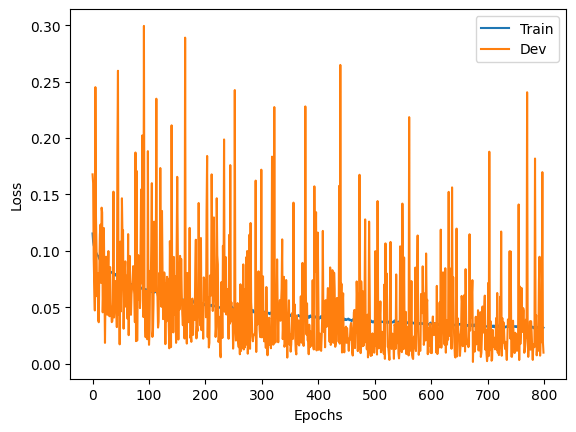

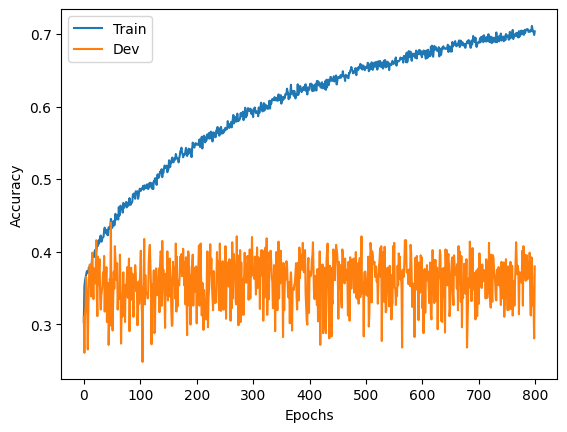

torch.Size([18, 7])
2610
              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1256
           1       0.23      0.20      0.21       345
           2       0.05      0.09      0.06        68
           3       0.04      0.06      0.05        50
           4       0.37      0.27      0.31       402
           5       0.18      0.18      0.18       208
           6       0.28      0.45      0.34       281

    accuracy                           0.39      2610
   macro avg       0.25      0.25      0.24      2610
weighted avg       0.41      0.39      0.39      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 7)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.3, 1/0.1, 1/0.05, 1/0.05, 1/0.15, 1/0.1, 1/0.1])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_e, testset_e, devset_e, y_e_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.2377, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1105, Dev Loss: 0.2377, Train Acc: 0.3421, Dev Acc: 0.3688
tensor(0.0625, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1018, Dev Loss: 0.0625, Train Acc: 0.3953, Dev Acc: 0.3147
tensor(0.0676, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.0969, Dev Loss: 0.0676, Train Acc: 0.3972, Dev Acc: 0.3562
tensor(0.0491, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.0921, Dev Loss: 0.0491, Train Acc: 0.4036, Dev Acc: 0.3886
tensor(0.1109, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.0884, Dev Loss: 0.1109, Train Acc: 0.4119, Dev Acc: 0.3877
tensor(0.1055, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.0841, Dev Loss: 0.1055, Train Acc: 0.4343, Dev Acc: 0.3913
tensor(0.0764, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.0818, Dev Loss: 0.0764, Train Acc: 0.4437, Dev Acc: 0.3580
tensor(0.0336, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.0788, Dev Loss: 0.0336, Train Acc: 0.4517, Dev Acc:

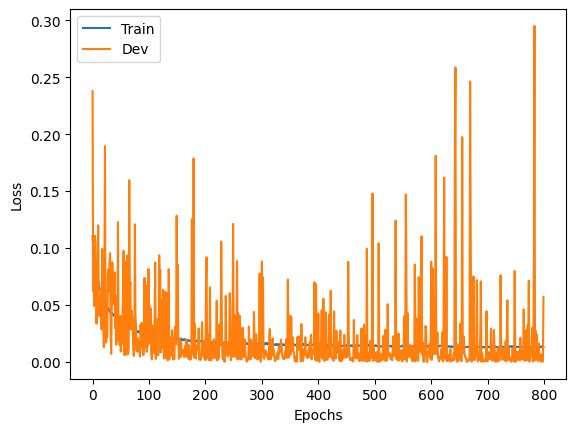

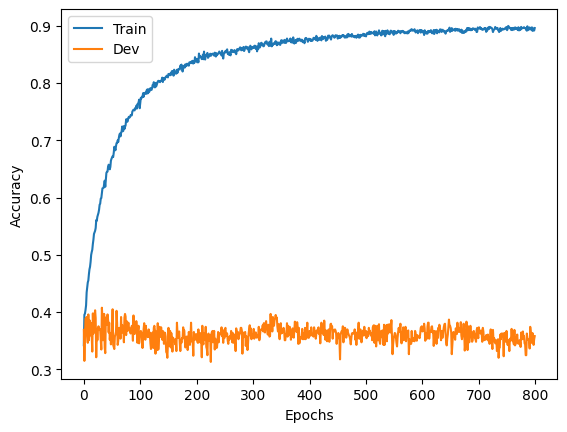

torch.Size([18, 7])
2610
              precision    recall  f1-score   support

           0       0.55      0.47      0.51      1256
           1       0.20      0.17      0.19       345
           2       0.10      0.15      0.12        68
           3       0.02      0.04      0.03        50
           4       0.29      0.37      0.32       402
           5       0.21      0.23      0.22       208
           6       0.32      0.33      0.32       281

    accuracy                           0.36      2610
   macro avg       0.24      0.25      0.24      2610
weighted avg       0.39      0.36      0.37      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.LSTM(input_size=300, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 7)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.3, 1/0.1, 1/0.05, 1/0.05, 1/0.15, 1/0.1, 1/0.1])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_e, testset_e, devset_e, y_e_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.0689, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1098, Dev Loss: 0.0689, Train Acc: 0.3451, Dev Acc: 0.3643
tensor(0.1047, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1010, Dev Loss: 0.1047, Train Acc: 0.3816, Dev Acc: 0.3517
tensor(0.1302, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.0986, Dev Loss: 0.1302, Train Acc: 0.3885, Dev Acc: 0.3472
tensor(0.0520, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.0973, Dev Loss: 0.0520, Train Acc: 0.3850, Dev Acc: 0.3814
tensor(0.0803, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.0962, Dev Loss: 0.0803, Train Acc: 0.3959, Dev Acc: 0.3490
tensor(0.0336, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.0942, Dev Loss: 0.0336, Train Acc: 0.3970, Dev Acc: 0.3760
tensor(0.0885, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.0928, Dev Loss: 0.0885, Train Acc: 0.3997, Dev Acc: 0.3625
tensor(0.0528, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.0928, Dev Loss: 0.0528, Train Acc: 0.3960, Dev Acc:

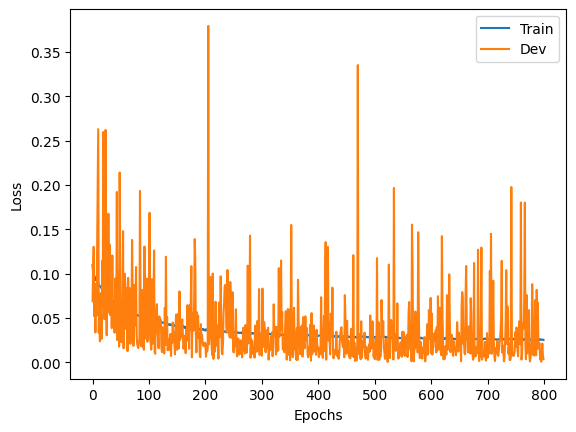

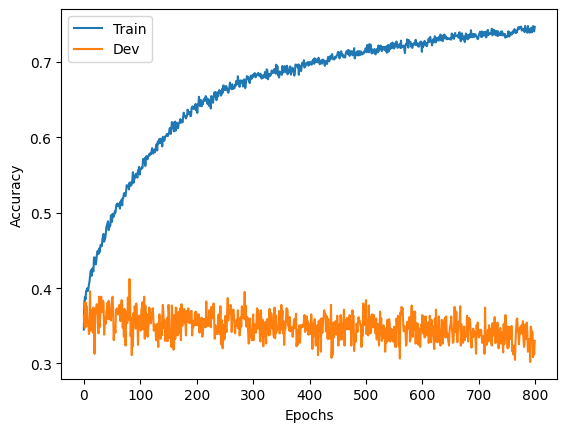

torch.Size([18, 7])
2610
              precision    recall  f1-score   support

           0       0.57      0.45      0.50      1256
           1       0.21      0.21      0.21       345
           2       0.08      0.10      0.09        68
           3       0.04      0.08      0.05        50
           4       0.33      0.38      0.35       402
           5       0.19      0.22      0.20       208
           6       0.29      0.40      0.33       281

    accuracy                           0.37      2610
   macro avg       0.24      0.26      0.25      2610
weighted avg       0.40      0.37      0.38      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.RNN(input_size=300, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 7)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.3, 1/0.1, 1/0.05, 1/0.05, 1/0.15, 1/0.1, 1/0.1])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_e, testset_e, devset_e, y_e_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.1277, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1552, Dev Loss: 0.1277, Train Acc: 0.4370, Dev Acc: 0.4491
tensor(0.1577, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1469, Dev Loss: 0.1577, Train Acc: 0.4756, Dev Acc: 0.4536
tensor(0.1448, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1442, Dev Loss: 0.1448, Train Acc: 0.4890, Dev Acc: 0.4572
tensor(0.1572, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1431, Dev Loss: 0.1572, Train Acc: 0.5043, Dev Acc: 0.4914
tensor(0.1899, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1415, Dev Loss: 0.1899, Train Acc: 0.5061, Dev Acc: 0.4572
tensor(0.0754, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1392, Dev Loss: 0.0754, Train Acc: 0.5157, Dev Acc: 0.4968
tensor(0.2198, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1383, Dev Loss: 0.2198, Train Acc: 0.5203, Dev Acc: 0.4454
tensor(0.0900, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1378, Dev Loss: 0.0900, Train Acc: 0.5280, Dev Acc:

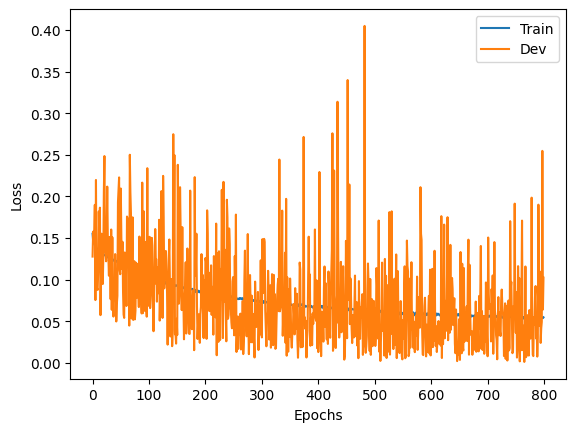

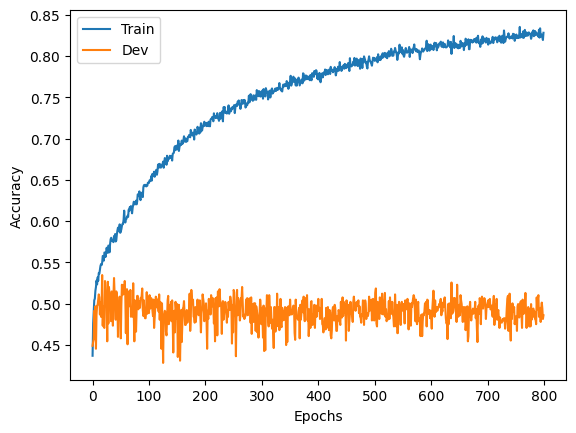

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.55      0.67      0.60      1256
           1       0.38      0.41      0.39       521
           2       0.48      0.29      0.36       833

    accuracy                           0.50      2610
   macro avg       0.47      0.46      0.45      2610
weighted avg       0.49      0.50      0.49      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.3, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.2906, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1652, Dev Loss: 0.2906, Train Acc: 0.4239, Dev Acc: 0.4112
tensor(0.1592, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1533, Dev Loss: 0.1592, Train Acc: 0.4642, Dev Acc: 0.4653
tensor(0.1426, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1508, Dev Loss: 0.1426, Train Acc: 0.4761, Dev Acc: 0.4644
tensor(0.1515, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1474, Dev Loss: 0.1515, Train Acc: 0.4922, Dev Acc: 0.4815
tensor(0.0945, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1478, Dev Loss: 0.0945, Train Acc: 0.4906, Dev Acc: 0.4779
tensor(0.1831, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1463, Dev Loss: 0.1831, Train Acc: 0.5046, Dev Acc: 0.4959
tensor(0.0733, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1449, Dev Loss: 0.0733, Train Acc: 0.4931, Dev Acc: 0.4761
tensor(0.2003, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1447, Dev Loss: 0.2003, Train Acc: 0.5139, Dev Acc:

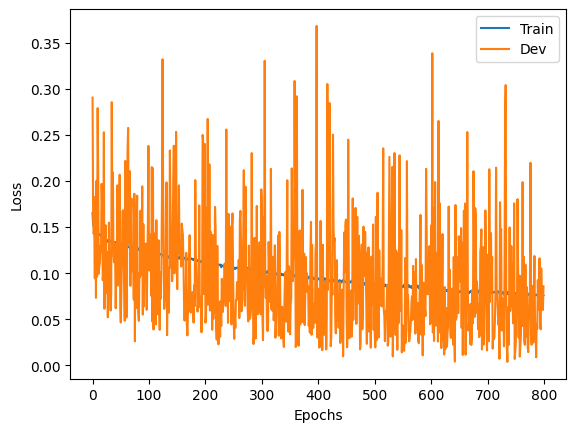

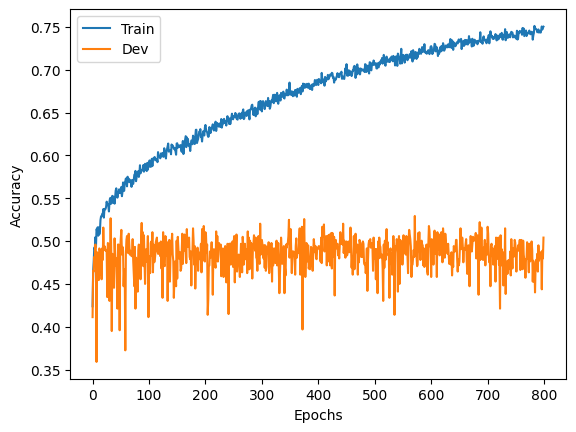

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.57      0.62      0.60      1256
           1       0.37      0.41      0.39       521
           2       0.46      0.37      0.41       833

    accuracy                           0.50      2610
   macro avg       0.47      0.47      0.46      2610
weighted avg       0.50      0.50      0.50      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=64, batch_first=False)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.3, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.1240, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1684, Dev Loss: 0.1240, Train Acc: 0.4004, Dev Acc: 0.4220
tensor(0.1636, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1550, Dev Loss: 0.1636, Train Acc: 0.4351, Dev Acc: 0.4013
tensor(0.1072, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1501, Dev Loss: 0.1072, Train Acc: 0.4617, Dev Acc: 0.4445
tensor(0.1254, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1478, Dev Loss: 0.1254, Train Acc: 0.4704, Dev Acc: 0.4842
tensor(0.1765, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1467, Dev Loss: 0.1765, Train Acc: 0.4728, Dev Acc: 0.4454
tensor(0.1102, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1456, Dev Loss: 0.1102, Train Acc: 0.4791, Dev Acc: 0.4554
tensor(0.1629, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1456, Dev Loss: 0.1629, Train Acc: 0.4778, Dev Acc: 0.4887
tensor(0.1242, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1440, Dev Loss: 0.1242, Train Acc: 0.4755, Dev Acc:

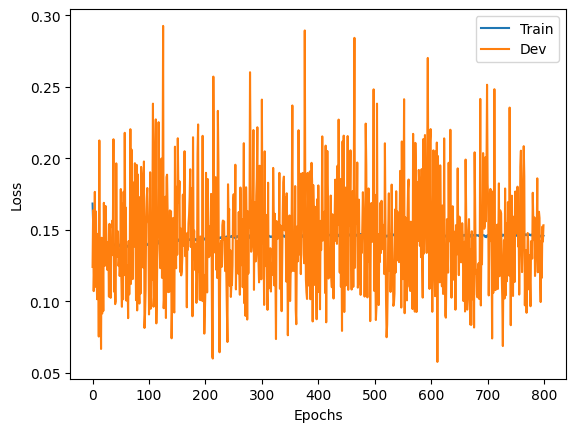

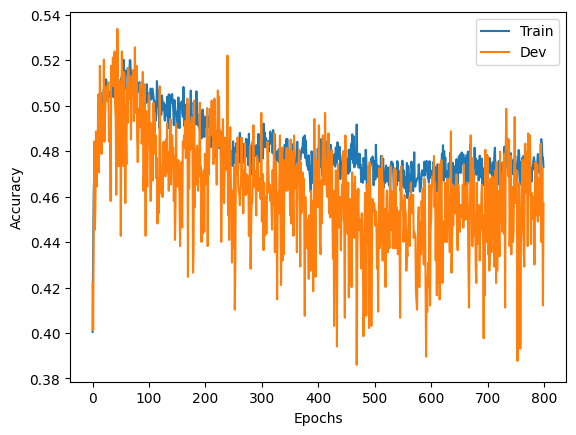

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.53      0.48      0.50      1256
           1       0.37      0.27      0.31       521
           2       0.40      0.52      0.45       833

    accuracy                           0.45      2610
   macro avg       0.43      0.42      0.42      2610
weighted avg       0.45      0.45      0.45      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=128, batch_first=False)
        self.gru2 = nn.GRU(input_size=128, hidden_size=64, batch_first=False)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.3, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.1325, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1419, Dev Loss: 0.1325, Train Acc: 0.5008, Dev Acc: 0.5446
tensor(0.1417, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1286, Dev Loss: 0.1417, Train Acc: 0.5631, Dev Acc: 0.5311
tensor(0.1273, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1215, Dev Loss: 0.1273, Train Acc: 0.5818, Dev Acc: 0.5140
tensor(0.1723, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1138, Dev Loss: 0.1723, Train Acc: 0.6165, Dev Acc: 0.5149
tensor(0.1334, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1061, Dev Loss: 0.1334, Train Acc: 0.6417, Dev Acc: 0.5176
tensor(0.0892, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.0984, Dev Loss: 0.0892, Train Acc: 0.6683, Dev Acc: 0.5320
tensor(0.0717, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.0904, Dev Loss: 0.0717, Train Acc: 0.6866, Dev Acc: 0.5131
tensor(0.0477, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.0825, Dev Loss: 0.0477, Train Acc: 0.7221, Dev Acc:

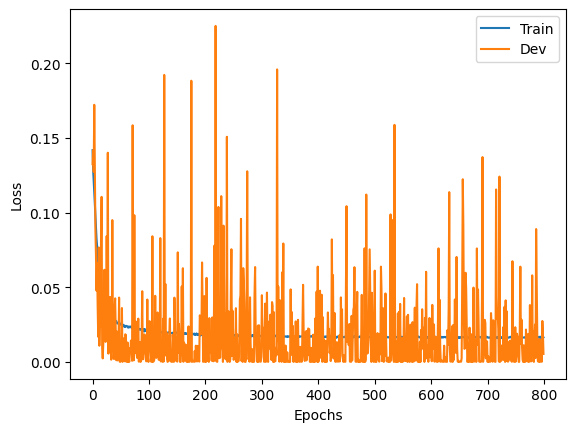

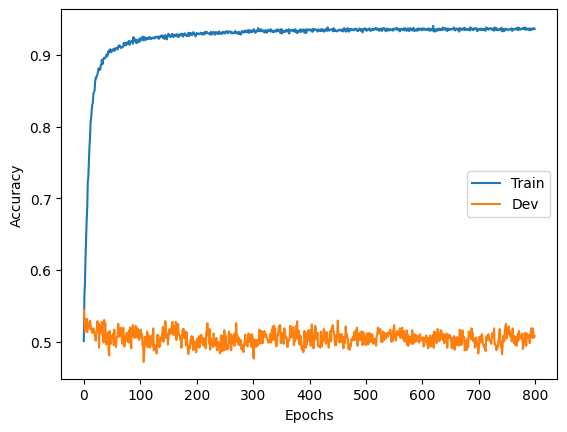

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1256
           1       0.37      0.41      0.39       521
           2       0.49      0.46      0.47       833

    accuracy                           0.51      2610
   macro avg       0.48      0.49      0.49      2610
weighted avg       0.52      0.51      0.51      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=128, batch_first=False)
        self.gru2 = nn.GRU(input_size=128, hidden_size=64, batch_first=False)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.3, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.001, epoch_size=800, loss=loss_function)

tensor(0.0957, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1055, Dev Loss: 0.0957, Train Acc: 0.3937, Dev Acc: 0.4031
tensor(0.1011, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1045, Dev Loss: 0.1011, Train Acc: 0.4339, Dev Acc: 0.4085
tensor(0.1007, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1041, Dev Loss: 0.1007, Train Acc: 0.4468, Dev Acc: 0.4094
tensor(0.0935, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1037, Dev Loss: 0.0935, Train Acc: 0.4507, Dev Acc: 0.4085
tensor(0.0868, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1033, Dev Loss: 0.0868, Train Acc: 0.4463, Dev Acc: 0.4076
tensor(0.0996, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1028, Dev Loss: 0.0996, Train Acc: 0.4457, Dev Acc: 0.4049
tensor(0.1250, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1022, Dev Loss: 0.1250, Train Acc: 0.4465, Dev Acc: 0.4175
tensor(0.0770, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1016, Dev Loss: 0.0770, Train Acc: 0.4476, Dev Acc:

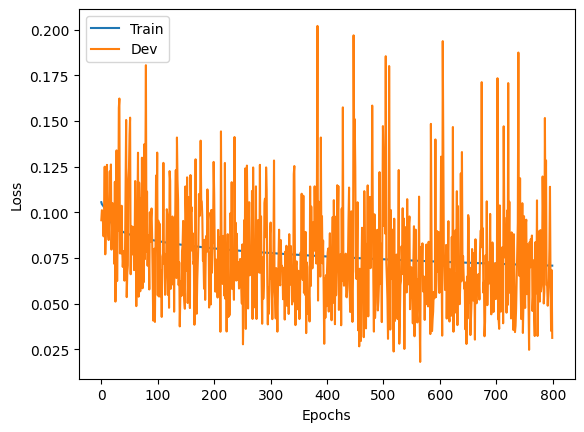

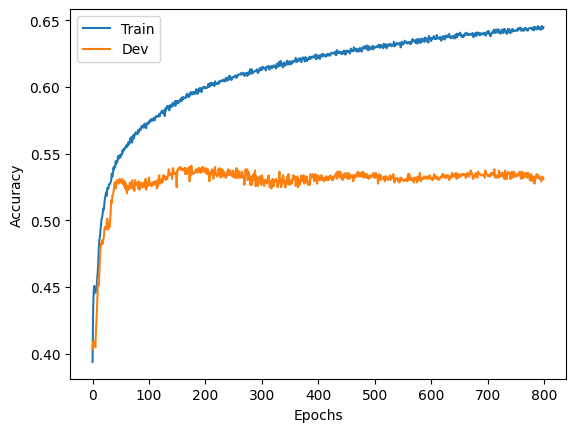

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1256
           1       0.46      0.44      0.45       521
           2       0.48      0.50      0.49       833

    accuracy                           0.54      2610
   macro avg       0.52      0.51      0.51      2610
weighted avg       0.54      0.54      0.54      2610



In [ ]:
class Net(nn.Module):
    def __init__(self,input_size, output_size):
        super().__init__()  #вх. #вых.
        self.fc1 = nn.Conv1d(1, 32, 3)
        self.fc2 = nn.Linear(9536, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.fc1(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)

net = Net(20, 3)
class_weights = torch.FloatTensor([1/0.35, 1/0.28, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=3, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.000001, epoch_size=800, loss=loss_function)

tensor(0.1196, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1552, Dev Loss: 0.1196, Train Acc: 0.4438, Dev Acc: 0.4364
tensor(0.1214, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1479, Dev Loss: 0.1214, Train Acc: 0.4634, Dev Acc: 0.4896
tensor(0.1177, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1453, Dev Loss: 0.1177, Train Acc: 0.4843, Dev Acc: 0.4842
tensor(0.0998, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1431, Dev Loss: 0.0998, Train Acc: 0.4992, Dev Acc: 0.4671
tensor(0.1716, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1427, Dev Loss: 0.1716, Train Acc: 0.4889, Dev Acc: 0.5023
tensor(0.1807, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1407, Dev Loss: 0.1807, Train Acc: 0.5034, Dev Acc: 0.4770
tensor(0.0701, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1412, Dev Loss: 0.0701, Train Acc: 0.5070, Dev Acc: 0.5149
tensor(0.1929, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1391, Dev Loss: 0.1929, Train Acc: 0.5142, Dev Acc:

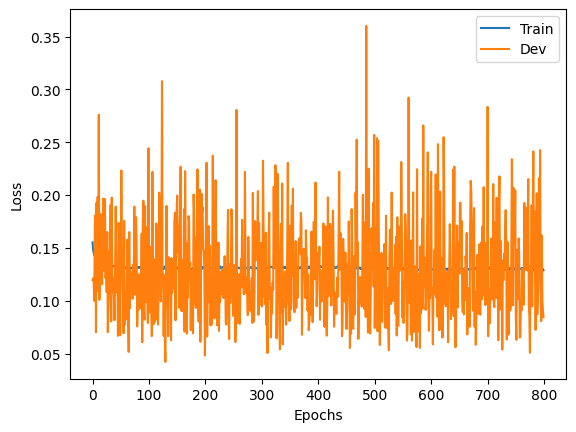

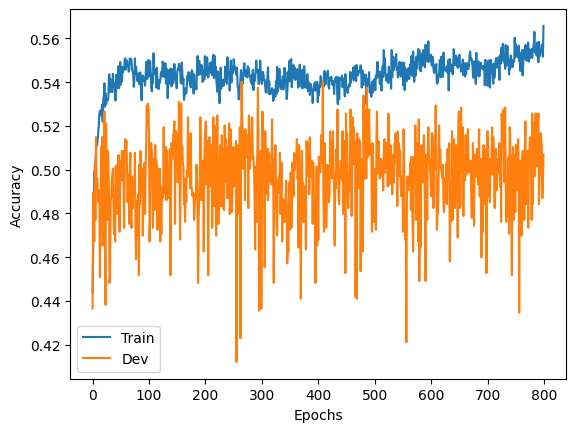

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1256
           1       0.39      0.35      0.37       521
           2       0.46      0.50      0.48       833

    accuracy                           0.50      2610
   macro avg       0.48      0.47      0.48      2610
weighted avg       0.50      0.50      0.50      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=64, batch_first=False)
        self.gru2 = nn.GRU(input_size=64, hidden_size=32, batch_first=False)
        self.fc = nn.Linear(32, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.3, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.1137, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1663, Dev Loss: 0.1137, Train Acc: 0.4237, Dev Acc: 0.4518
tensor(0.0928, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1529, Dev Loss: 0.0928, Train Acc: 0.4576, Dev Acc: 0.4518
tensor(0.2402, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1503, Dev Loss: 0.2402, Train Acc: 0.4753, Dev Acc: 0.4238
tensor(0.1276, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1486, Dev Loss: 0.1276, Train Acc: 0.4816, Dev Acc: 0.4653
tensor(0.1088, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1481, Dev Loss: 0.1088, Train Acc: 0.4883, Dev Acc: 0.4806
tensor(0.0626, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1451, Dev Loss: 0.0626, Train Acc: 0.5037, Dev Acc: 0.4932
tensor(0.1190, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1450, Dev Loss: 0.1190, Train Acc: 0.5035, Dev Acc: 0.4833
tensor(0.1912, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1429, Dev Loss: 0.1912, Train Acc: 0.5111, Dev Acc:

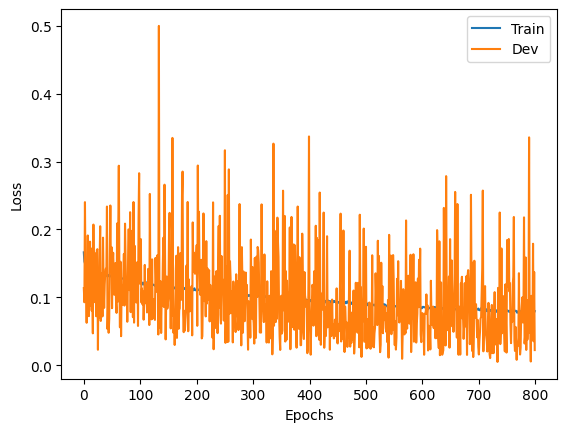

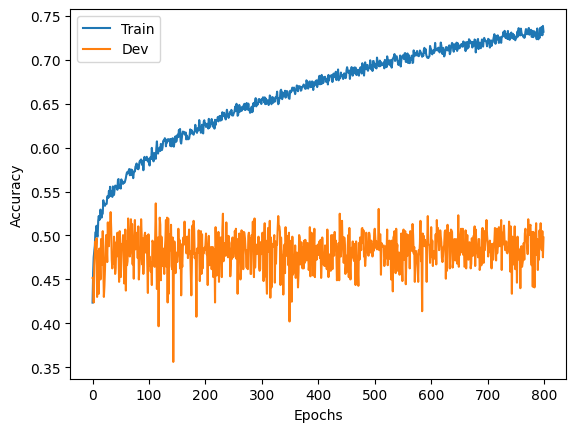

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      1256
           1       0.38      0.39      0.38       521
           2       0.46      0.47      0.47       833

    accuracy                           0.51      2610
   macro avg       0.48      0.48      0.48      2610
weighted avg       0.51      0.51      0.51      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.3, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.1718, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1643, Dev Loss: 0.1718, Train Acc: 0.4188, Dev Acc: 0.4301
tensor(0.1682, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1543, Dev Loss: 0.1682, Train Acc: 0.4550, Dev Acc: 0.4463
tensor(0.1804, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1504, Dev Loss: 0.1804, Train Acc: 0.4717, Dev Acc: 0.4301
tensor(0.1340, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1495, Dev Loss: 0.1340, Train Acc: 0.4777, Dev Acc: 0.4184
tensor(0.1328, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1489, Dev Loss: 0.1328, Train Acc: 0.4867, Dev Acc: 0.4878
tensor(0.0708, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1482, Dev Loss: 0.0708, Train Acc: 0.4847, Dev Acc: 0.4833
tensor(0.1017, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1468, Dev Loss: 0.1017, Train Acc: 0.4905, Dev Acc: 0.4932
tensor(0.1450, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1447, Dev Loss: 0.1450, Train Acc: 0.5034, Dev Acc:

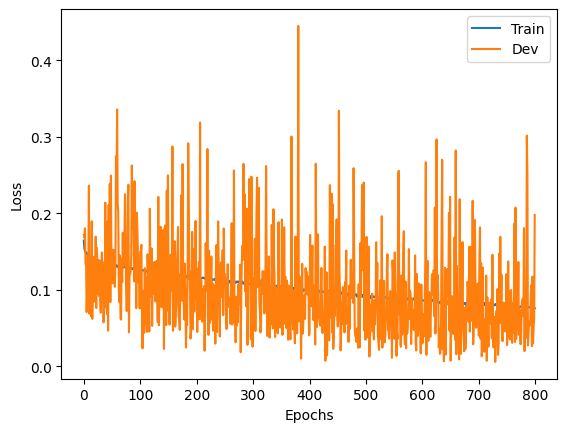

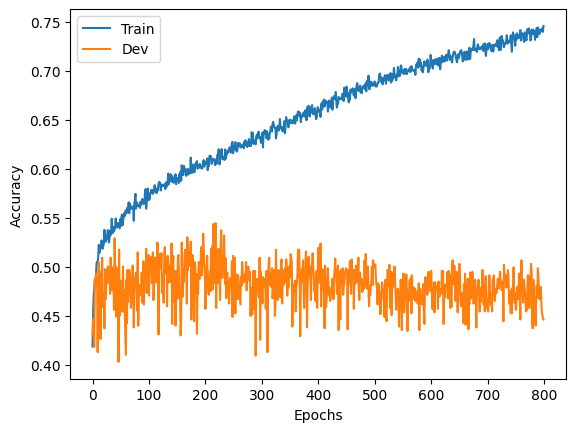

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.58      0.38      0.46      1256
           1       0.32      0.43      0.37       521
           2       0.41      0.54      0.46       833

    accuracy                           0.44      2610
   macro avg       0.44      0.45      0.43      2610
weighted avg       0.47      0.44      0.44      2610



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(input_size=300, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.28, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

tensor(0.2135, grad_fn=<MeanBackward0>)
Epoch 1/800, Train Loss: 0.1655, Dev Loss: 0.2135, Train Acc: 0.4208, Dev Acc: 0.4220
tensor(0.2504, grad_fn=<MeanBackward0>)
Epoch 2/800, Train Loss: 0.1537, Dev Loss: 0.2504, Train Acc: 0.4561, Dev Acc: 0.4382
tensor(0.1471, grad_fn=<MeanBackward0>)
Epoch 3/800, Train Loss: 0.1506, Dev Loss: 0.1471, Train Acc: 0.4699, Dev Acc: 0.4653
tensor(0.0549, grad_fn=<MeanBackward0>)
Epoch 4/800, Train Loss: 0.1490, Dev Loss: 0.0549, Train Acc: 0.4883, Dev Acc: 0.4545
tensor(0.0807, grad_fn=<MeanBackward0>)
Epoch 5/800, Train Loss: 0.1474, Dev Loss: 0.0807, Train Acc: 0.4870, Dev Acc: 0.4509
tensor(0.1228, grad_fn=<MeanBackward0>)
Epoch 6/800, Train Loss: 0.1477, Dev Loss: 0.1228, Train Acc: 0.4929, Dev Acc: 0.4743
tensor(0.1244, grad_fn=<MeanBackward0>)
Epoch 7/800, Train Loss: 0.1454, Dev Loss: 0.1244, Train Acc: 0.5006, Dev Acc: 0.4914
tensor(0.0792, grad_fn=<MeanBackward0>)
Epoch 8/800, Train Loss: 0.1453, Dev Loss: 0.0792, Train Acc: 0.5044, Dev Acc:

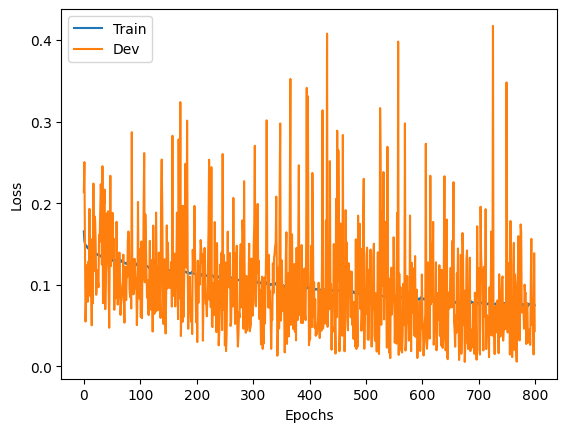

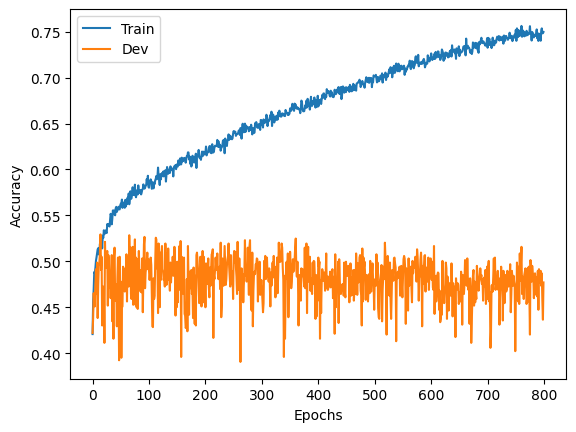

torch.Size([18, 3])
2610
              precision    recall  f1-score   support

           0       0.59      0.50      0.54      1256
           1       0.37      0.43      0.40       521
           2       0.45      0.50      0.47       833

    accuracy                           0.49      2610
   macro avg       0.47      0.48      0.47      2610
weighted avg       0.50      0.49      0.49      2610



In [ ]:
class SimpleRNN(nn.Module):
  def __init__(self):
    super(SimpleRNN, self).__init__()
    self.rnn1 = nn.RNN(300, 64,batch_first=False, bidirectional=True)
    self.fc = nn.Linear(64, 3)

  def forward(self, x):
    x, _ = self.rnn1(x)
    x = self.fc(x)
    return F.log_softmax(x, dim=1)


net = Net()
class_weights = torch.FloatTensor([1/0.35, 1/0.28, 1/0.25])
class_weights = class_weights / torch.sum(class_weights)
loss_function = FocalLoss(gamma=2, alpha=class_weights)
train(net,trainset_s, testset_s, devset_s, y_s_test, op='rms', sch='multistep', IR=0.01, epoch_size=800, loss=loss_function)

### **Вывод 2.3 Усложнение моделей для тональности**
|label_name|feature|classifier|hidden_size|num_layers|label_0_f1_score|label_1_f1_score|label_2_f1_score|weighted\_avg\_f1-score|
|---|---|---|---|---|---|---|--|---|
|Sentiment|w2v\_pred|CNN|32|1|0\.61|0\.45|0\.49|0\.54|
|Sentiment|w2v\_pred|GRU|[128,64]|2|0\.59|0\.39|0\.47|0\.51|
|Sentiment|w2v\_pred|GRU|64|1|0\.60|0\.39|0\.41|0\.50|
|Sentiment|w2v\_pred|GRU|32|1|0\.60|0\.39|0\.36|0\.49|
|Sentiment|w2v\_pred|GRU|32|1|0\.55|0\.34|0\.40|0\.46|
|Sentiment|w2v\_pred|CNN|64|1|0\.59|0\.02|0\.47|0\.44|
|Sentiment|w2v\_pred|Linear|32|1|0\.60|0\.24|0\.32|0\.44|
|Sentiment|w2v\_pred|Linear|[32,16]|1|0\.57|0\.31|0\.30|0\.43|

### **Вывод 2.4 Усложнение моделей для эмоций**
|label_name|feature|classifier|hidden_size|num_layers|label_0_f1_score|label_1_f1_score|label_2_f1_score|label_3_f1_score|label_4_f1_score|label_5_f1_score|label_6_f1_score|weighted\_avg\_f1-score|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Emotion|word2vec\_pred|GRU|32|1|0\.55|0\.21|0\.06|0\.05|0\.31|0\.18|0\.34|0\.39|
|Emotion|word2vec\_pred|RNN|32|1|0\.50|0\.21|0\.09|0\.05|0\.35|0\.20|0\.33|0\.38|
|Emotion|word2vec\_pred|LSTM|32|1|0\.51|0\.19|0\.12|0\.03|0\.32|0\.22|0\.32|0\.37|